# Building Neuron Tensors
Resources that have been useful:
* [key resource] Stanford tutorial: https://cs231n.github.io/convolutional-networks/
* [key resource] Stackexchange that makes all this clear with a simple example: https://stackoverflow.com/questions/52272592/how-many-neurons-does-the-cnn-input-layer-have
----
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
* https://hackernoon.com/learning-keras-by-implementing-vgg16-from-scratch-d036733f2d5

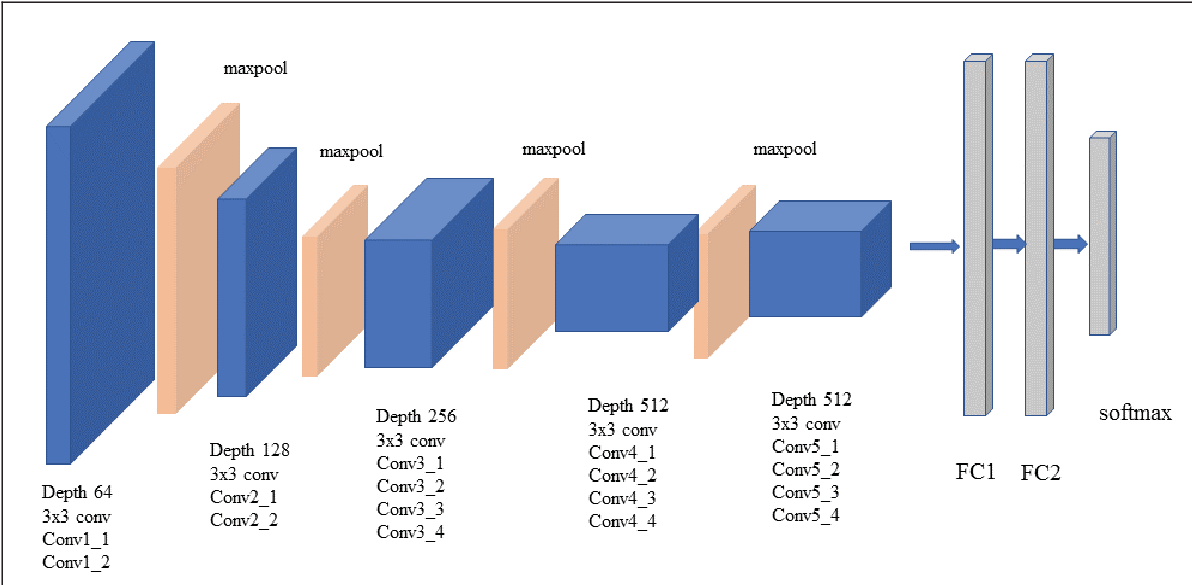

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math
import pathlib
import datetime
from scipy.io import savemat
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time

In [2]:
!pip install git+https://github.com/ahwillia/tensortools
import tensortools as tt
from scipy.ndimage import gaussian_filter

  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-t00ze0dm
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-t00ze0dm
  Created wheel for tensortools: filename=tensortools-0.3-py3-none-any.whl size=47993 sha256=84d3eefe1496f0283441769a4a261164c589c859abd29ff22f6badb67558998a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ebd64zhw/wheels/1c/a5/81/96b292bf9d9e3e00a29f59864a212f082de8221f254a82e159
Successfully built tensortools


In [3]:
import numpy as np
import torch
import random 
import os

default_seed = 4142 
def seed_everything(seed = 1234):
  random.seed(seed)
  tseed = random.randint(1,1E6)
  tcseed = random.randint(1,1E6)
  npseed = random.randint(1,1E6)
  ospyseed = random.randint(1,1E6)
  torch.manual_seed(tseed)
  torch.cuda.manual_seed_all(tcseed)
  np.random.seed(npseed)
  os.environ['PYTHONHASHSEED'] = str(ospyseed)

seed_everything(default_seed)

* load a pre-trained network (VGG16)
* input images from CIFAR-10 to VGG16
* choose some random unit in one of the layers and plot its activity for different images

## Load VGG16 model

In [4]:
from keras.applications.vgg16 import VGG16
MAX_SIZE = 64
VGG16_Model = VGG16(include_top=False, weights='imagenet',input_shape=(MAX_SIZE, MAX_SIZE, 3))
VGG16_Model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [5]:
# add new classifier layers
flat1 = Flatten()(VGG16_Model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
VGG16_Model = Model(inputs=VGG16_Model.inputs, outputs=output)

In [6]:
VGG16_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [7]:
from google.colab import drive 
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Embeddings/code'

Mounted at /content/drive/
/content/drive/My Drive/Embeddings/code


# Create 3D neuron tensor: 

In [8]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        DEBUG NOTE: PYTORCH IS (#channels, rows, cols)!!
        im, an image of shape (3, im_size, im_size)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal, note that the channel for tf and pytorch are in different dimension
    im_size_vertical = im.shape[0]
    im_size_horizontal = im.shape[1]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=1)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=2)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

Note: 
output size = [(W−K+2P)/S]+1 = (128-3)/3+1 = ~43

e.g. conv_layer
W is the input volume - 128
K is the Kernel size - 3
P is the padding - 0
S is the stride - 3

edge_neuron = floor(filter_size /stride) = floor(3/3) = 1

In [9]:
def compute_neuron_output(model, layer_indices, im_all_shifts,  max_indices = None, n_max_feature_maps = 5, plot_activity = False):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        im_all_shifts: all shifts of one particular image in the for loop
    return:
        
    '''
    print(im_all_shifts.shape)
    n_shifts = im_all_shifts.shape[0]
    n_layers = len(layer_indices)
    neuron_output_highest = []
    all_fm_avg = []
    im_all_shifts = np.array(im_all_shifts)
    
    for layer_index in layer_indices:
        layer = model.layers[layer_index] 
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        ## note: always take the images as inputs
        output_layer = K.function(inputs=[model.layers[1].input], 
                              outputs=[layer.output])
        
        ## output is n feature maps
        neuron_output = output_layer(im_all_shifts)[0]
        print(neuron_output.shape)
        ## number of neurons is nrow * ncol * n_feature_maps
        n_shifts, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
 
        filter_size = 3
        shift_step = 3
        edge_neuron = math.floor(filter_size / shift_step)
        neuron_output = neuron_output[:, edge_neuron:(n_row - edge_neuron), edge_neuron:(n_col - edge_neuron),:]
        n_shifts, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        neuron_output = neuron_output.reshape((n_shifts, n_row * n_col, n_feature_maps))
        
        ## number of neurons for each feature map is nrow * ncol
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_shifts, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## the shape of neuron_output_by_fm is (n_shifts, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.transpose(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg and fm_max are of shape (n_shifts, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]

        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

        if plot_activity == True:
            print("Current layer: " + layer.name)
            print("Indices of FM with highest average firing rate in response to each image: " )
            max_fm_ind = np.argmax(fm_avg,axis = 1)
            print(max_fm_ind)
            print("#neurons in the FM with highest average firing rate: " + str(n_row * n_col))
            print("Average activity for all feature maps in " + layer.name)
            plt.matshow(fm_avg)
            plt.show()
            print('----------------------------------------------------\n')
        
        temp = neuron_output_by_fm[0,max_fm_ind[0],:].reshape(1, n_row * n_col)
    neuron_output_highest = np.empty((n_shifts, n_neurons * n_max_feature_maps))
    fm_avg_all_layers = fm_avg_all_layers
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers
    
    for i in range(n_shifts):
        if max_indices is None:
            max_indices = np.argpartition(fm_avg_all_layers[i], -n_max_feature_maps , axis = 0)[-n_max_feature_maps:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max_indices, :].reshape((1,n_neurons * n_max_feature_maps))

    ## normalize neuron output, note that the shape of neuron_output_highest is (n_shifts, n_max_feature_maps, #neurons)
    neuron_output_highest = neuron_output_highest.reshape((n_shifts, n_max_feature_maps, n_neurons))
    ## shape of fm_diff is (n_shifts, n_max_feature_maps)
    fm_diff = neuron_output_highest.max(axis = 2) - neuron_output_highest.min(axis = 2) 

    for i in range(n_max_feature_maps):
      a = neuron_output_highest[i]
      b = fm_diff[i].reshape((fm_diff[i].shape[0],1))
      ## deal with division by zero: https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero
      neuron_output_highest[i] =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    neuron_labels = []
    for i in range(n_max_feature_maps):
      neuron_labels += [i] * n_neurons
    neuron_labels = np.array(neuron_labels) 

    neuron_output_highest = neuron_output_highest.reshape((n_shifts, n_neurons * n_max_feature_maps))

    return neuron_output_highest, fm_avg_all_layers, neuron_labels, max_indices, n_neurons

In [10]:
def show_stimuli_3D(model, layer_indices, images_selected_classes, shifts, max_indices, n_images_selected_classes, shift_step = 3, n_max_feature_maps = 5, plot_activity = False):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''

    if shifts is False:
        neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output(
            model, layer_indices, images_selected_classes, max_indices, n_max_feature_maps, plot_activity)
  
    else: 
        # generate shifts for each selected image and then stack: 
        neuron_output_highest_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, shift_step)
            im_all_shifts = torch.Tensor(im_all_shifts)
            
            ## neuron_output_highest is of shape (n_shifts, n_neurons * n_max_feature_maps)
            neuron_output_highest, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output(
                model, layer_indices, im_all_shifts, max_indices, n_max_feature_maps, plot_activity)
        
            ## instead of taking average, we create a dimension for all shifts (analogous to the time dimension)

            neuron_output_highest_with_shifts.append(neuron_output_highest)

            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
        
        ## out of for loop!      
        ## neuron_output_highest_with_shifts is of shape (n_images_selected_classes, n_shifts, n_neurons * n_max_feature_maps)
        neuron_output_highest_with_shifts = np.array(neuron_output_highest_with_shifts)
        neuron_output_highest_final = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
(5, 64, 64, 3)


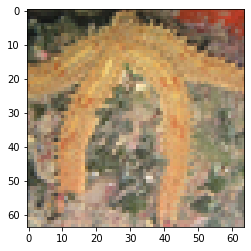

In [11]:
!python3 -m pip install --upgrade pip
!python3 -m pip install --upgrade Pillow
from PIL import Image, ImageTk
img_array = np.load('imgnet_starfish.npy')
def get_images_selected_classes(num_images):
  images_selected_classes = []
  MAX_SIZE = 64
  for i in range(num_images):
    im = Image.fromarray(img_array[i,:,:,:].astype(np.uint8))
    im.thumbnail((MAX_SIZE, MAX_SIZE), Image.ANTIALIAS)
    images_selected_classes.append(np.array(im))
  ##  (#images, #nrow, #ncol, #channels) 
  images_selected_classes = np.array(images_selected_classes)
  
  return images_selected_classes

num_images = 5
images_selected_classes = get_images_selected_classes(num_images)
print(images_selected_classes.shape)
plt.imshow(images_selected_classes[0])

In [12]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max_indices = show_stimuli_3D(
    VGG16_Model, range(2), images_selected_classes, shifts = True,  max_indices = None, n_images_selected_classes = num_images, n_max_feature_maps=5, plot_activity = True)

torch.Size([484, 64, 64, 3])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-33deb90bd207>", line 2, in <module>
    VGG16_Model, range(2), images_selected_classes, shifts = True,  max_indices = None, n_images_selected_classes = num_images, n_max_feature_maps=5, plot_activity = True)
  File "<ipython-input-10-f30eee12a831>", line 25, in show_stimuli_3D
    model, layer_indices, im_all_shifts, max_indices, n_max_feature_maps, plot_activity)
  File "<ipython-input-9-36ea86a9d1cd>", line 29, in compute_neuron_output
    neuron_output = output_layer(im_all_shifts)[0]
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py", line 4113, in func
    outs = model(model_inputs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 1044, in __call__
    outputs = call_fn(inputs, *args,

KeyboardInterrupt: ignored

In [ ]:
neuron_output_highest_with_shifts.shape

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
from scipy.io import savemat
mdic = {"neuron_output_3D": data}
mdic
savemat("neuron_output_3D_vgg_conv1.mat", mdic)

In [ ]:
data.shape

(19220, 5, 484)

484 is the number of shifts = 22 * 22
5 is the number of selected images
19220 = 5 * 62 * 62 , where 5 is the number of feature maps and 62 is the number of neurons

# Create 2D neuron tensor:

In [ ]:
def show_stimuli_2D(model, layer_indices, images_selected_classes, shifts, max_indices, n_images_selected_classes, shift_step = 3, n_max_feature_maps = 5, plot_activity = False):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''

    if shifts is False:
        neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output(
            model, layer_indices, images_selected_classes, max_indices, n_max_feature_maps, plot_activity) 
  
  
    else: 
        # generate shifts for each selected image and then stack: 
        neuron_output_highest_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, shift_step)
            im_all_shifts = torch.Tensor(im_all_shifts)
            
            ## neuron_output_highest is of shape (n_shifts, n_neurons * n_max_feature_maps)
            neuron_output_highest, fm_avg_all_layers, neuron_labels, max_indices, n_neurons = compute_neuron_output(
                model, layer_indices, im_all_shifts, max_indices, n_max_feature_maps, plot_activity) 
  

            ## take the average over all shifts of im
            neuron_output_highest_shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0] 
            neuron_output_highest_shifts_avg = neuron_output_highest_shifts_avg.reshape((1, neuron_output_highest_shifts_avg.shape[0]))


            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
              neuron_output_highest_with_shifts = neuron_output_highest_shifts_avg 
              fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
              neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, neuron_output_highest_shifts_avg))
              fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
        
        ## out of for loop!      
        ## neuron_output_highest_with_shifts is of shape (n_images_selected_classes, n_shifts, n_neurons * n_max_feature_maps)
        neuron_output_highest_with_shifts = np.array(neuron_output_highest_with_shifts)
        neuron_output_highest_final = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest_final, fm_avg_all_layers, neuron_labels, max_indices

torch.Size([484, 64, 64, 3])
(484, 64, 64, 64)
Current layer: block1_conv1
Indices of FM with highest average firing rate in response to each image: 
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 3

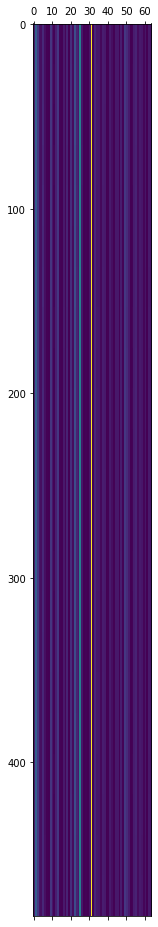

----------------------------------------------------

torch.Size([484, 64, 64, 3])
(484, 64, 64, 64)
Current layer: block1_conv1
Indices of FM with highest average firing rate in response to each image: 
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31

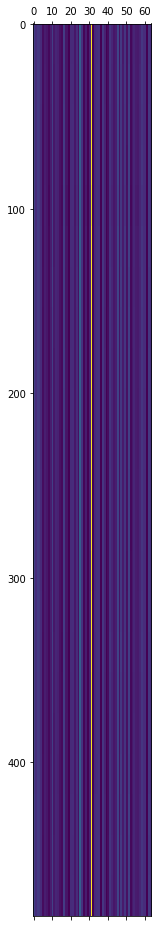

----------------------------------------------------

torch.Size([484, 64, 64, 3])
(484, 64, 64, 64)
Current layer: block1_conv1
Indices of FM with highest average firing rate in response to each image: 
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31

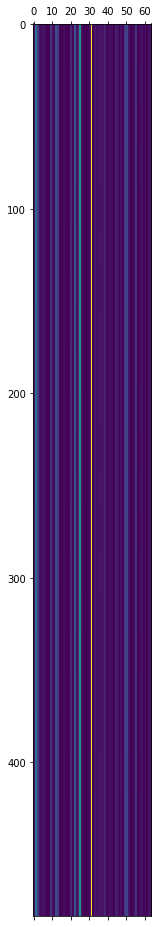

----------------------------------------------------

torch.Size([484, 64, 64, 3])
(484, 64, 64, 64)
Current layer: block1_conv1
Indices of FM with highest average firing rate in response to each image: 
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31

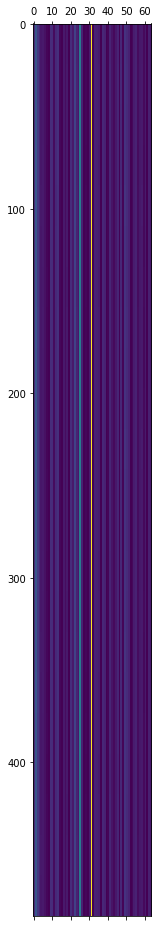

----------------------------------------------------

torch.Size([484, 64, 64, 3])
(484, 64, 64, 64)
Current layer: block1_conv1
Indices of FM with highest average firing rate in response to each image: 
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31

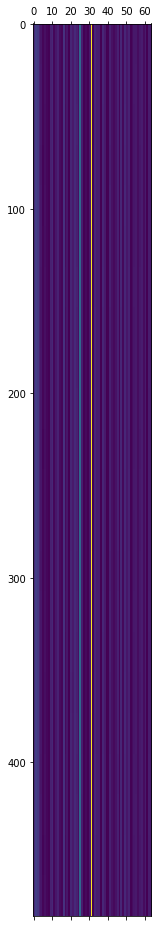

----------------------------------------------------



In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max_indices = show_stimuli_2D(
    VGG16_Model, range(2), images_selected_classes, shifts = True,  max_indices = None, n_images_selected_classes = num_images, n_max_feature_maps=5, plot_activity = True)

In [ ]:
neuron_output_highest_with_shifts.shape

(5, 19220)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1,0))
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
mdic
savemat("neuron_output_2D_vgg_conv1.mat", mdic)

# Streamline tensor factorization:

In [23]:
from scipy.io import loadmat
N_vgg_3D = loadmat("neuron_output_3D_vgg_conv1.mat")['neuron_output_3D']
N_vgg_2D = loadmat("neuron_output_2D_vgg_conv1.mat")['neuron_output_2D']

In [16]:
def get_tensor_factors(N, dim = 3, n_vertical_shifts = 22, ranks = [10, 20, 30], reps = 5):
## note that for 2D tensor (ie a matrix), rank + nullity = num_columns => rank <= num_columns
  if dim == 3:
    N_filtered = np.empty(N.shape)
    for i in range(N.shape[0]):
      for j in range(N.shape[1]):
        filtered = gaussian_filter(N[i,j,:].reshape((n_vertical_shifts, n_vertical_shifts)), sigma=1).reshape((n_vertical_shifts * n_vertical_shifts,))
        N_filtered[i,j,:] = filtered[:]
  else:
    N_filtered = N.reshape((N.shape[0], N.shape[1], 1))

  # Fit ensembles of tensor decompositions:
  methods = (
    'ncp_hals',  # fits nonnegative tensor decomposition.
  )

  ensembles = {}
  for m in methods:
      ensembles[m] = tt.Ensemble(fit_method=m,  fit_options=dict(tol=1e-5))
      ensembles[m].fit(N_filtered, ranks=ranks, replicates=reps)
      ## replicates: int, number of models to fit at each rank

  ## plot objective, similarity, factors:
  """
  Customized plotting routines for CP decompositions
  """

  # Plotting options for the unconstrained and nonnegative models.
  plot_options = {
    'ncp_hals': {
      'line_kw': {
        'color': 'blue',
        'alpha': 1,
        'label': 'ncp_hals',
      },
      'scatter_kw': {
        'color': 'blue',
        'alpha': 1,
        's': 1,
      },
    },
  }

  def plot_objective(ensemble, partition='train', ax=None, jitter=0.1,
                    scatter_kw=dict(), line_kw=dict()):
      """Plots objective function as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      partition : string, one of: {'train', 'test'}
          specifies whether to plot the objective function on the training
          data or the held-out test set.
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      """

      if ax is None:
          ax = plt.gca()

      if partition == 'train':
          pass
      elif partition == 'test':
          raise NotImplementedError('Cross-validation is on the TODO list.')
      else:
          raise ValueError("partition must be 'train' or 'test'.")

      # compile statistics for plotting
      x, obj, min_obj = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          o = ensemble.objectives(rank)
          obj.extend(o)
          x.extend(np.full(len(o), rank))
          min_obj.append(min(o))

      print(o)
      print(obj)
      print(x)
      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot objectives for all iterations
      ax.scatter(x, obj, **scatter_kw)
      ax.plot(ux, min_obj, **line_kw)
      ax.set_xlabel('model rank')
      ax.set_ylabel('objective')

      return ax


  def plot_similarity(ensemble, ax=None, jitter=0.1,
                      scatter_kw=dict(), line_kw=dict()):
      """Plots similarity across optimization runs as a function of model rank.
      Parameters
      ----------
      ensemble : Ensemble object
          holds optimization results across a range of model ranks
      ax : matplotlib axis (optional)
          axis to plot on (defaults to current axis object)
      jitter : float (optional)
          amount of horizontal jitter added to scatterpoints (default=0.1)
      scatter_kw : dict (optional)
          keyword arguments for styling the scatterpoints
      line_kw : dict (optional)
          keyword arguments for styling the line
      References
      ----------
      Ulrike von Luxburg (2010). Clustering Stability: An Overview.
      Foundations and Trends in Machine Learning.
      https://arxiv.org/abs/1007.1075
      """

      if ax is None:
          ax = plt.gca()

      # compile statistics for plotting
      x, sim, mean_sim = [], [], []
      for rank in sorted(ensemble.results):
          # reconstruction errors for rank-r models
          s = ensemble.similarities(rank)[1:]
          sim.extend(s)
          x.extend(np.full(len(s), rank))
          mean_sim.append(np.mean(s))

      # add horizontal jitter
      ux = np.unique(x)
      x = np.array(x) + (np.random.rand(len(x))-0.5)*jitter

      # make plot
      # customized: plot similarities for all iterations
      ax.scatter(x, sim, **scatter_kw)
      ax.plot(ux, mean_sim, **line_kw)

      ax.set_xlabel('model rank')
      ax.set_ylabel('model similarity')
      ax.set_ylim([0, 1.1])

      return ax

  # Plot similarity and error plots.
  plt.figure()
  for m in methods:
      plot_objective(ensembles[m], **plot_options[m])
  plt.legend()

  plt.figure()
  for m in methods:
      plot_similarity(ensembles[m], **plot_options[m])
  plt.legend()

  plt.show()

  tensor_factors = []
  for rank in ranks:
    tensor_factors.append(ensembles['ncp_hals'].results[rank][0].factors[0])

  return tensor_factors ## A LIST!

In [55]:
def get_embeddings(tensor_factors_best_rank,neuron_labels,n_dim_PCA = 10): 
  # PCA on tensor factors 
  pca = PCA(n_dim_PCA)
  neuron_output_highest_with_shifts_PCA =  pca.fit_transform(tensor_factors_best_rank)
  neuron_output_highest_with_shifts_PCA.shape
  vectors, lambdas = pca.components_, pca.explained_variance_
  plt.plot(pca.explained_variance_ratio_)
  plt.show()

  # plot embeddings:

  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_output_highest_with_shifts_PCA
  print(data.shape)
  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels == label)
      print(mask.shape)
      print(label, sum(mask))
      traces.append(go.Scatter3d(
          x=data[mask,0],
          y=data[mask,1],
          z=data[mask,2],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))

  for trace in traces:
      fig.add_trace(trace)
  fig.update_layout(
    
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,
                    # scene = dict(xaxis = dict(range=[-1.5,2.5],),
                    #              yaxis = dict(range=[-1.5,1.5],),
                    #              zaxis = dict(range=[-1.5,1.5],),),
                    )
  fig.show()
  return neuron_output_highest_with_shifts_PCA

In [32]:
def colorFromUnivariateData(Z1, cmap1 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)

    # Color for each point
    Z_color = np.array(Z1_color[:,0:3])
    return Z_color

## ## https://stackoverflow.com/questions/49871436/scatterplot-with-continuous-bivariate-color-palette-in-python

def colorFromBivariateData(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color , Z2_color ], axis=0)/2.0
    Z_color = np.array(Z_color[:,0:3])
    return Z_color

def get_spatial_order_plot(cluster_index, neuron_output_highest_with_shifts_PCA, neuron_labels, n_max_feature_maps = 5):
  n_neurons = int(neuron_labels.shape[0]/n_max_feature_maps)
  neuron_cluster = neuron_output_highest_with_shifts_PCA[cluster_index * n_neurons : (cluster_index + 1) * n_neurons]
  neuron_labels_cluster = neuron_labels[cluster_index * n_neurons : (cluster_index + 1) * n_neurons]
  xs, ys = np.mgrid[0:62,0:62]
  xs = xs.reshape((3844,))
  ys = ys.reshape((3844,))

  import plotly.graph_objects as go
  import plotly.express as px

  fig = go.Figure()
  traces = []
  colors_palette = px.colors.qualitative.Dark24
  data = neuron_cluster

  for i, label in enumerate(set(neuron_labels)):
      mask = (neuron_labels_cluster == label)
      print(label, sum(mask))
      traces.append(go.Scatter3d(
          x=data[mask,0],
          y=data[mask,1],
          z=data[mask,2],
          mode='markers',
          marker=dict(
              size=4,
              color=colors_palette[int(label)],
              opacity=1,
              #showscale= True,
          )))
  for trace in traces:
      fig.add_trace(trace)
  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
  fig.show()

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  data = neuron_cluster
  ax.scatter(
          data[:,0],
          data[:,1],
          data[:,2],
          c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
          s = 100,
          alpha= 1
          ) 
  plt.show()

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  data = neuron_cluster
  ax.scatter(
          data[:,0],
          data[:,1],
          data[:,2],
          c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
          s = 100,
          alpha= 1
          ) 
  plt.show()

In [19]:
def get_tensor_factors_plot(tensor_factors_best_rank, best_rank, n_max_feature_maps):
  plt.plot(tensor_factors_best_rank[:,0])
  plt.show()

  for i in range(best_rank):
    factor = tensor_factors_best_rank[:,i]
    feature_map_side = 62
    vmin = factor.min()
    vmax = factor.max()
    f, axes = plt.subplots(1,n_max_feature_maps,figsize=(10,1))
    for f_i, ax in enumerate(axes):
      feature_map_matrix = factor[(f_i * feature_map_side ** 2): ((f_i+1) * feature_map_side ** 2)].reshape((feature_map_side, feature_map_side))
      ax.imshow(feature_map_matrix, vmin = vmin, vmax = vmax)
      ax.set(xticks = [], yticks = [])
    plt.show()

##3D:

In [24]:
N_vgg_3D.shape

(19220, 5, 484)

Fitting rank-10 models:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/usr/local/lib/python3.7/dist-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                      

Rank-10 models:  min obj, 0.11;  max obj, 0.11;  time to fit, 517.6s


Rank-12 models:  min obj, 0.10;  max obj, 0.10;  time to fit, 667.7s


Rank-15 models:  min obj, 0.09;  max obj, 0.09;  time to fit, 722.4s


[0.08749427348780238, 0.08751380039730783, 0.08756765986305197, 0.08772760791313672, 0.09124164011587636]
[0.10758342869359346, 0.10762641847502558, 0.10783728622758111, 0.10862586538842789, 0.10870306823231038, 0.09822556483556105, 0.09844753099683083, 0.09872957647732068, 0.0987557933880423, 0.09919788037939271, 0.08749427348780238, 0.08751380039730783, 0.08756765986305197, 0.08772760791313672, 0.09124164011587636]
[10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 15, 15, 15, 15, 15]


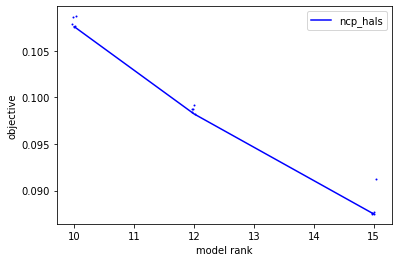

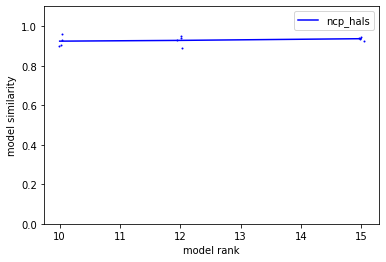

In [25]:
tensor_factors = get_tensor_factors(N_vgg_3D, ranks = [10,12,15])

In [28]:
neuron_labels = []
for i in range(5):
  neuron_labels += [i] * 3844
neuron_labels = np.array(neuron_labels) 

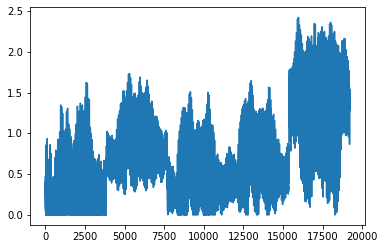

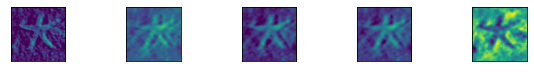

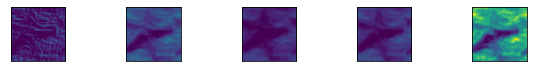

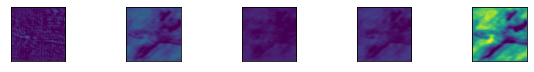

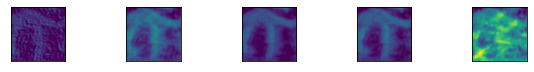

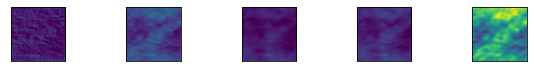

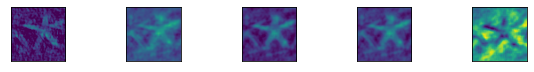

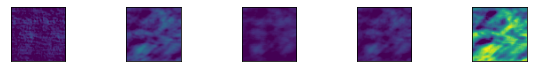

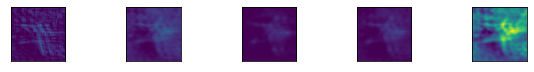

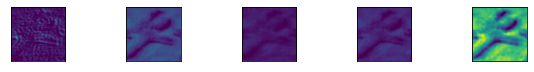

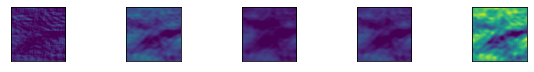

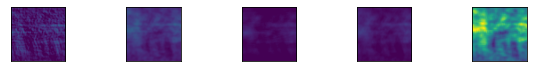

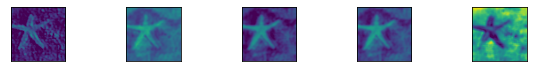

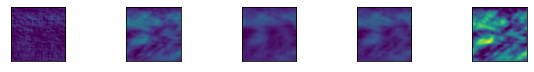

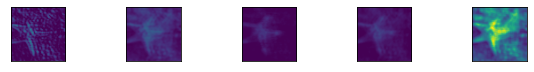

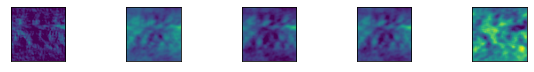

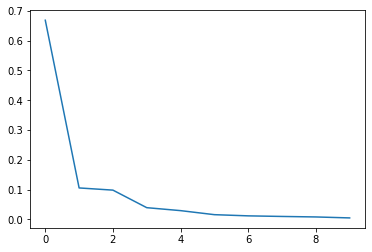

(19220, 10)
(19220,)
0 3844
(19220,)
1 3844
(19220,)
2 3844
(19220,)
3 3844
(19220,)
4 3844


0 0
1 3844
2 0
3 0
4 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



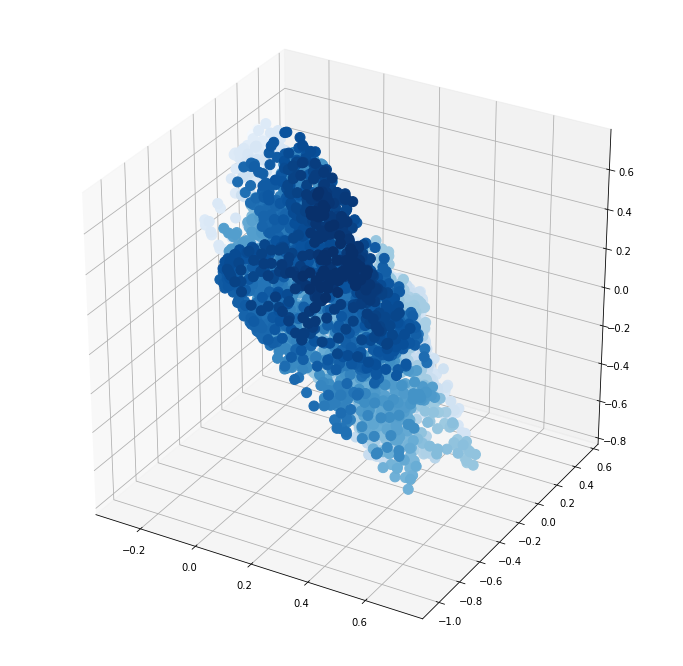

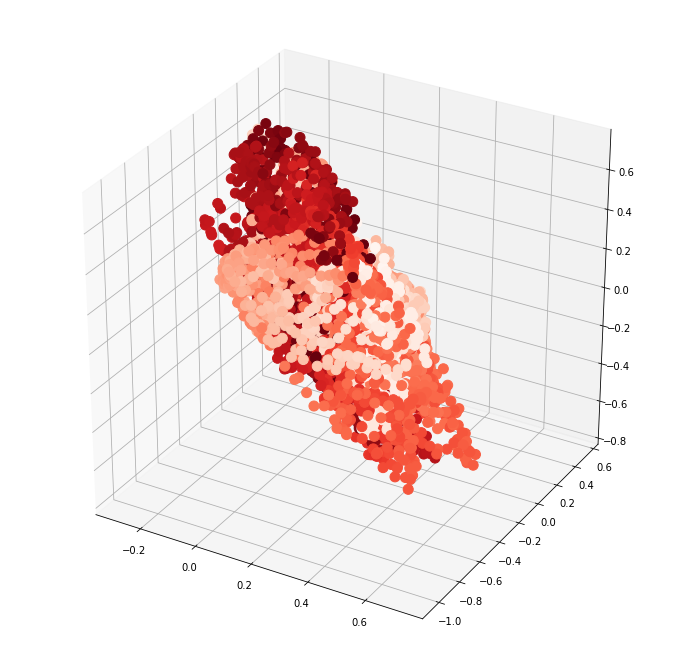

In [34]:
tensor_factors_best_rank = tensor_factors[2]
get_tensor_factors_plot(tensor_factors_best_rank, best_rank=15, n_max_feature_maps=5)
neuron_output_highest_with_shifts_PCA = get_embeddings(tensor_factors_best_rank, neuron_labels)
get_spatial_order_plot(1, neuron_output_highest_with_shifts_PCA, neuron_labels)

In [ ]:
neuron_output_highest_with_shifts.shape

(5, 484, 19220)

In [ ]:
fm_avg_all_layers_with_shifts.shape

(5, 128)

In [ ]:
neuron_labels

array([0, 0, 0, ..., 4, 4, 4])

In [35]:
for i in range(64):
  plt.plot(fm_avg_all_layers_with_shifts[:,i]/max(fm_avg_all_layers_with_shifts[:,i]))
plt.show()

NameError: ignored

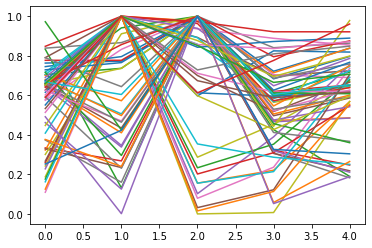

In [ ]:
for i in range(64,128):
  plt.plot(fm_avg_all_layers_with_shifts[:,i]/max(fm_avg_all_layers_with_shifts[:,i]))
plt.show()

(-0.5, 127.5, 4.5, -0.5)

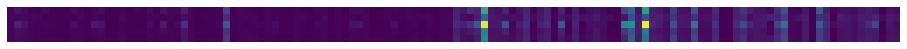

In [ ]:
plt.matshow(fm_avg_all_layers_with_shifts, cmap = 'viridis')
plt.axis('off')

## 2D:

In [36]:
N_vgg_2D.shape

(19220, 5)

Rank-2 models:  min obj, 0.11;  max obj, 0.11;  time to fit, 1.3s


Rank-3 models:  min obj, 0.07;  max obj, 0.07;  time to fit, 3.9s


Rank-4 models:  min obj, 0.05;  max obj, 0.05;  time to fit, 4.6s


Rank-5 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 19.1s


Rank-6 models:  min obj, 0.00;  max obj, 0.00;  time to fit, 57.1s


[0.0018976322591773389, 0.0020243569736519812, 0.0024400360611107927, 0.0024633510867036524, 0.002639673710814339]
[0.10818307916582151, 0.10819500776511644, 0.10829701955013273, 0.10830972092769732, 0.10832042489182837, 0.07332927794672545, 0.07342788871615714, 0.0734790002987182, 0.07347953613493972, 0.07352100007724248, 0.04739978593230169, 0.04740506337804707, 0.04742937603939435, 0.047477918735338825, 0.04751120150711776, 0.0022043091386443423, 0.0024425377547200233, 0.0026574369144857233, 0.0032633818468906597, 0.003312328227940523, 0.0018976322591773389, 0.0020243569736519812, 0.0024400360611107927, 0.0024633510867036524, 0.002639673710814339]
[2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6]


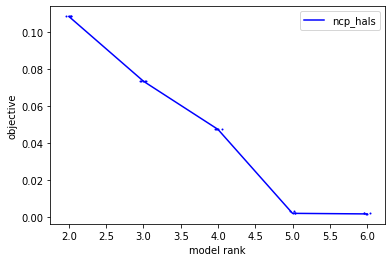

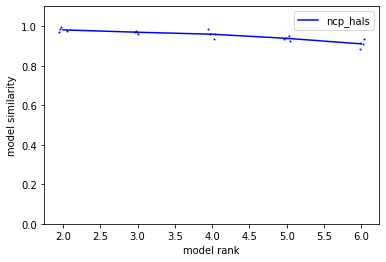

In [41]:
tensor_factors = get_tensor_factors(N_vgg_2D, dim =2, ranks=[2,3,4,5,6])

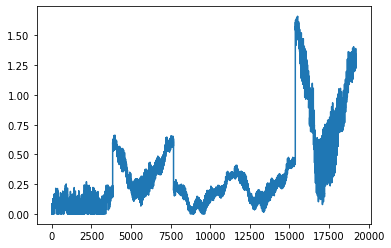

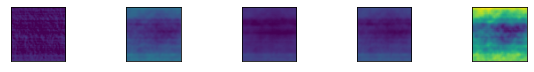

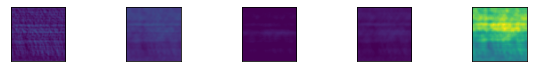

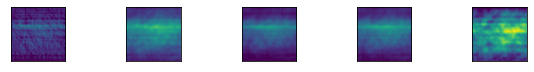

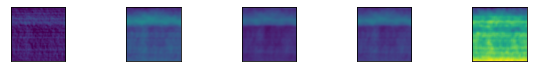

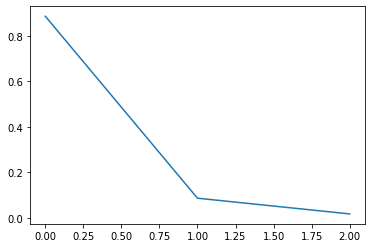

(19220, 3)
(19220,)
0 3844
(19220,)
1 3844
(19220,)
2 3844
(19220,)
3 3844
(19220,)
4 3844


0 0
1 3844
2 0
3 0
4 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



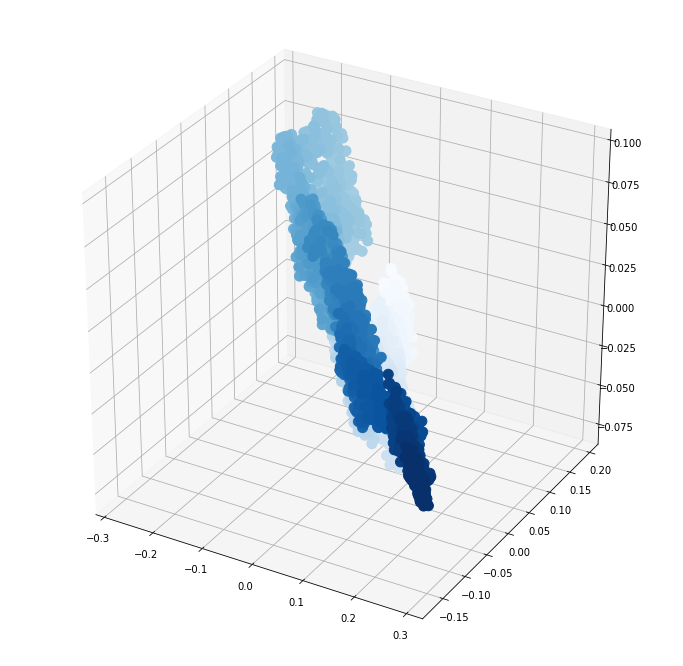

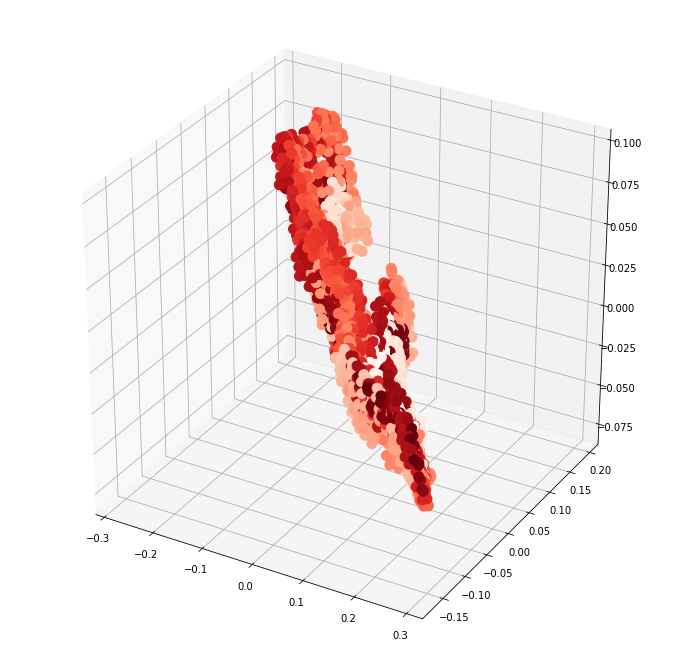

In [56]:
best_rank = 4
tensor_factors_best_rank = tensor_factors[2]
get_tensor_factors_plot(tensor_factors_best_rank, best_rank=4, n_max_feature_maps=5)
neuron_output_highest_with_shifts_PCA = get_embeddings(tensor_factors_best_rank, neuron_labels, n_dim_PCA = 3)
get_spatial_order_plot(1, neuron_output_highest_with_shifts_PCA, neuron_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



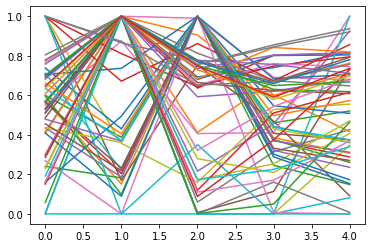

In [ ]:
for i in range(64):
  plt.plot(fm_avg_all_layers_with_shifts[:,i]/max(fm_avg_all_layers_with_shifts[:,i]))
plt.show()

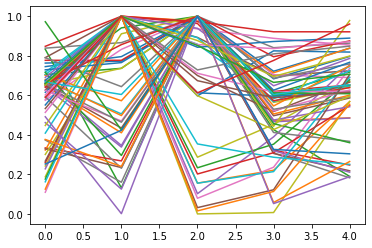

In [ ]:
for i in range(64,128):
  plt.plot(fm_avg_all_layers_with_shifts[:,i]/max(fm_avg_all_layers_with_shifts[:,i]))
plt.show()

### if stimuli = images with no shifts:

Current layer: block1_conv1
Indices of FM with highest average firing rate in response to each image: 
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31]
#neurons in the FM with highest average firing rate: 1024
Average activity for all feature maps in block1_conv1


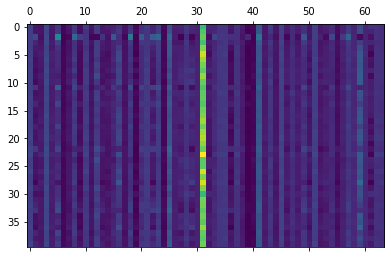

----------------------------------------------------

Current layer: block1_conv2
Indices of FM with highest average firing rate in response to each image: 
[ 4  4 52  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
#neurons in the FM with highest average firing rate: 1024
Average activity for all feature maps in block1_conv2


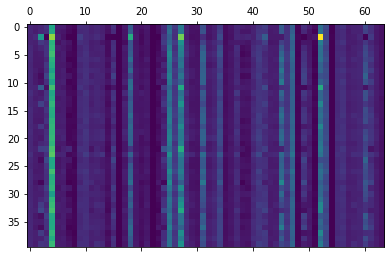

----------------------------------------------------

Current layer: block2_conv1
Indices of FM with highest average firing rate in response to each image: 
[ 20  20  56  15 125  15  15  20  15 125  20  15 125 125 125 125 125 125
  15 125  15  20  15 125  15  15  15 125 119  15 125  15  15 107  20 125
  15  15  15  15]
#neurons in the FM with highest average firing rate: 256
Average activity for all feature maps in block2_conv1


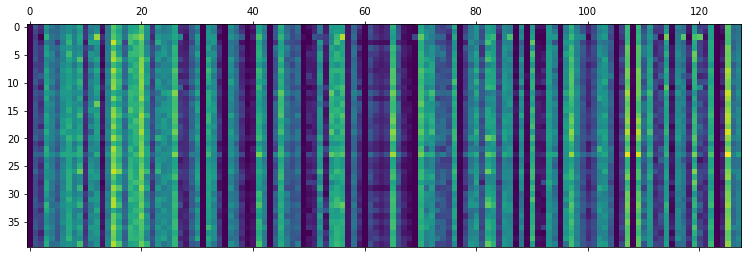

----------------------------------------------------

Current layer: block2_conv2
Indices of FM with highest average firing rate in response to each image: 
[103  85  85 103 100  85 103 125 103 125 103 100 125 125  85 103 103 125
 103 100 103 125 103  85 103 103 103 125  85 103 100 103 103  85 125 100
 103  85 103 103]
#neurons in the FM with highest average firing rate: 256
Average activity for all feature maps in block2_conv2


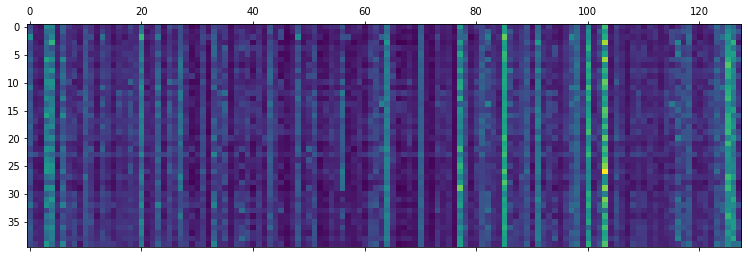

----------------------------------------------------

Current layer: block3_conv1
Indices of FM with highest average firing rate in response to each image: 
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]
#neurons in the FM with highest average firing rate: 64
Average activity for all feature maps in block3_conv1


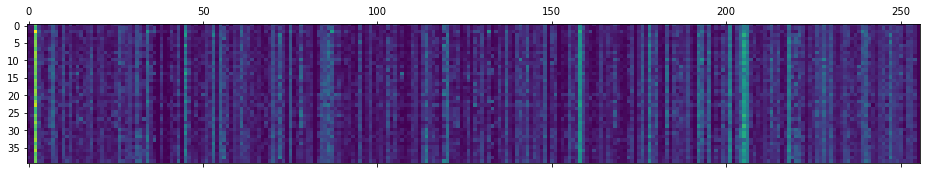

----------------------------------------------------

Current layer: block3_conv2
Indices of FM with highest average firing rate in response to each image: 
[65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65
 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65]
#neurons in the FM with highest average firing rate: 64
Average activity for all feature maps in block3_conv2


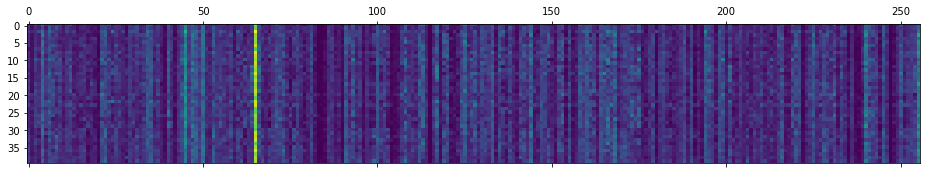

----------------------------------------------------

Current layer: block3_conv3
Indices of FM with highest average firing rate in response to each image: 
[54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54
 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54]
#neurons in the FM with highest average firing rate: 64
Average activity for all feature maps in block3_conv3


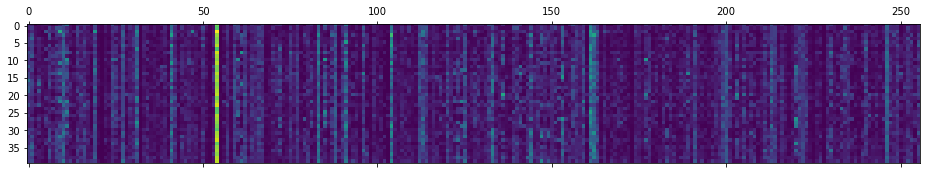

----------------------------------------------------

Current layer: block4_conv1
Indices of FM with highest average firing rate in response to each image: 
[461 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461
 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461 461
 461 461 461 461]
#neurons in the FM with highest average firing rate: 16
Average activity for all feature maps in block4_conv1


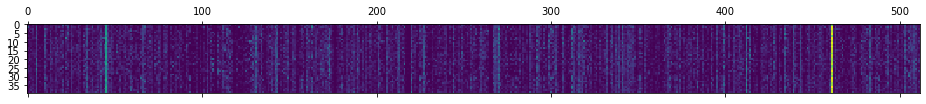

----------------------------------------------------

Current layer: block4_conv2
Indices of FM with highest average firing rate in response to each image: 
[ 24  24  24  24  24  24  24 142 143  24  24  24 143  24 470  24  24 436
  24  24  24  24 118  24 142  95 223  24  24  24  24  24  24  24  24 142
  24  24  24  24]
#neurons in the FM with highest average firing rate: 16
Average activity for all feature maps in block4_conv2


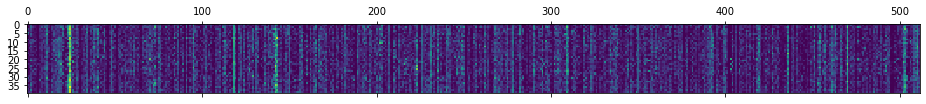

----------------------------------------------------

Current layer: block4_conv3
Indices of FM with highest average firing rate in response to each image: 
[296 363 486  30 435 486 296  92 118 273 460  30 121 378  30 454 213 173
  34 464 296  30 443 296 296 363 201 463 460  30 468 435 363 486 486 486
  30 486 282 486]
#neurons in the FM with highest average firing rate: 16
Average activity for all feature maps in block4_conv3


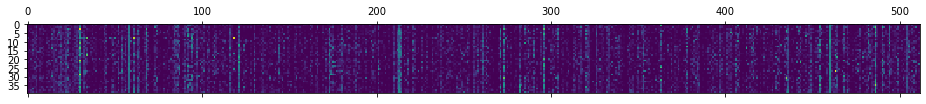

----------------------------------------------------

Current layer: block5_conv1
Indices of FM with highest average firing rate in response to each image: 
[410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410
 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410
 410 410 410 410]
#neurons in the FM with highest average firing rate: 4
Average activity for all feature maps in block5_conv1


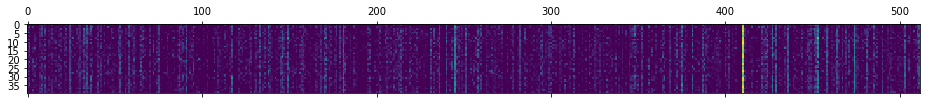

----------------------------------------------------

Current layer: block5_conv2
Indices of FM with highest average firing rate in response to each image: 
[ 89  55 394  55  55  89  55 391 400  55  55  55  89  55  55  89  55 391
  89  89  55  55  89  55  55  55  55  55 167  55 492  55  55 399  89 391
  55 399  55  89]
#neurons in the FM with highest average firing rate: 4
Average activity for all feature maps in block5_conv2


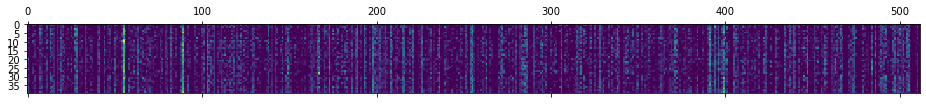

----------------------------------------------------

Current layer: block5_conv3
Indices of FM with highest average firing rate in response to each image: 
[155 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155
 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155 155
 155 155 155 155]
#neurons in the FM with highest average firing rate: 4
Average activity for all feature maps in block5_conv3


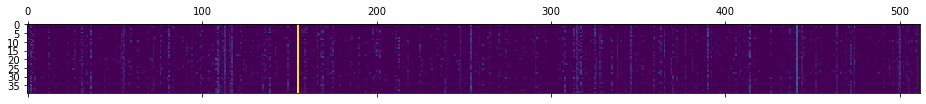

----------------------------------------------------



In [ ]:
neuron_output_highest_no_shifts, fm_avg_all_layers_no_shifts, neuron_labels = show_stimuli(layer_indices = range(20), n_images_per_class = 10, image_classes = [3,1,0,5], shifts = False, plot_activity = True)

### without image normalization:

In [ ]:
plt.matshow(neuron_output_highest_no_shifts )

In [ ]:
plt.plot(fm_avg_all_layers_no_shifts[:,5]/max(fm_avg_all_layers_no_shifts[:,5]))
plt.plot(fm_avg_all_layers_no_shifts[:,15]/max(fm_avg_all_layers_no_shifts[:,15]))
plt.show()

In [ ]:
fm_5_no_shifts = fm_avg_all_layers_no_shifts[:,5]/max(fm_avg_all_layers_no_shifts[:,5])
fm_15_no_shifts = fm_avg_all_layers_no_shifts[:,15]/max(fm_avg_all_layers_no_shifts[:,15])

In [ ]:
plt.plot(abs(fm_5_no_shifts - fm_15_no_shifts))
plt.show()

In [ ]:
first_neuron = neuron_output_highest_no_shifts[0:10,1]
first_neuron = first_neuron.reshape((10,1))
first_neuron